
**Contexte : Le jeu de données Décathlon**    
Le jeu de données Décathlon contient les performances de plusieurs athlètes sur 10 disciplines de l’épreuve du décathlon. Chaque colonne représente une discipline (course, lancer, saut, etc.), et chaque ligne correspond à un athlète.

**Variables disponibles :**

- Épreuves de course : 100m, 400m, 1500m, 110m haies
- Épreuves de saut : Longueur, Hauteur, Perche
- Épreuves de lancer : Poids, Disque, Javelot
- Score total   
💡 Les épreuves sont exprimées en différentes unités (secondes, mètres, points). Une standardisation est nécessaire avant l'ACP.

**Etapes à suivre**
1. Charger le jeu de données "decathlon.csv" et afficher un aperçu des données.
1. Vérifier et traiter les valeurs manquantes si nécessaire.
1. Standardiser les données (moyenne = 0, variance = 1) pour éviter les biais liés aux unités différentes.
1. Appliquer une ACP pour réduire la dimensionnalité des données.
1. Identifier les axes principaux et interpréter les regroupements d’épreuves dans l’espace factoriel.
1. Appliquer l’algorithme K-Means sur les premières composantes principales obtenues.
1. Déterminer le nombre optimal de clusters à l’aide de la méthode du coude.
1. Visualiser les clusters d’athlètes dans l’espace réduit de l’ACP.
1. Interpréter les groupes formés : Quels sont les profils types d’athlètes ? Quelles disciplines sont déterminantes pour la classification ?

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("decathlon.csv")
df.head()

,Athlets,100m,Long.jump,Shot.put,High.jump,400m,110m.hurdle,Discus,Pole.vault,Javeline,1500m,Rank,Points,Competition
0,SEBRLE,11.04,7.58,14.83,2.07,49.81,14.69,43.75,5.02,63.19,291.7,1,8217,Decastar
1,CLAY,10.76,7.40,14.26,1.86,49.37,14.05,50.72,4.92,60.15,301.5,2,8122,Decastar
2,KARPOV,11.02,7.30,14.77,2.04,48.37,14.09,48.95,4.92,50.31,300.2,3,8099,Decastar
3,BERNARD,11.02,7.23,14.25,1.92,48.93,14.99,40.87,5.32,62.77,280.1,4,8067,Decastar
4,YURKOV,11.34,7.09,15.19,2.10,50.42,15.31,46.26,4.72,63.44,276.4,5,8036,Decastar


In [3]:
df = df.drop(['Athlets',"Competition"], axis=1)

In [4]:
df.dtypes

100m           float64
Long.jump      float64
Shot.put       float64
High.jump      float64
400m           float64
110m.hurdle    float64
Discus         float64
Pole.vault     float64
Javeline       float64
1500m          float64
Rank             int64
Points           int64
dtype: object

In [5]:
df.isnull().sum()

100m           0
Long.jump      0
Shot.put       0
High.jump      0
400m           0
110m.hurdle    0
Discus         0
Pole.vault     0
Javeline       0
1500m          0
Rank           0
Points         0
dtype: int64

In [6]:
df.shape

(41, 12)

In [7]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

In [8]:
pca = PCA(n_components=12)
pca_df = pca.fit_transform(scaled_df)

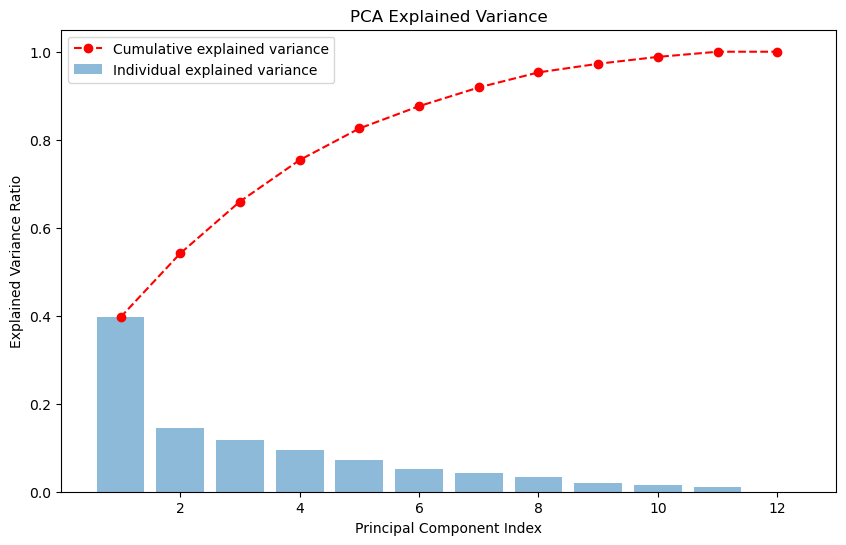

In [9]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='red', label="Cumulative explained variance")
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.show()

In [10]:
pca = PCA(n_components=6)
pca_df = pca.fit_transform(scaled_df)
loadings = pca.components_.T

cos2 = (loadings ** 2) / np.sum(loadings ** 2, axis=1, keepdims=True)

# Affichage
cos2_df = pd.DataFrame(cos2, index=list(df.columns), columns=[f"PC{i+1}" for i in range(cos2.shape[1])])
print("Qualité de représentation (cos²) des variables :\n", cos2_df)

Qualité de représentation (cos²) des variables :
                   PC1       PC2       PC3       PC4       PC5       PC6
100m         0.195654  0.026510  0.031275  0.069647  0.569256  0.107658
Long.jump    0.421074  0.223360  0.082315  0.000162  0.009171  0.263919
Shot.put     0.228269  0.625497  0.000815  0.030686  0.017905  0.096828
High.jump    0.090062  0.092215  0.050116  0.008215  0.233663  0.525728
400m         0.268338  0.466908  0.032282  0.018363  0.017031  0.197078
110m.hurdle  0.328754  0.076359  0.014679  0.466914  0.045650  0.067643
Discus       0.096638  0.360930  0.003462  0.108206  0.018047  0.412717
Pole.vault   0.006233  0.033031  0.495590  0.433462  0.016981  0.014703
Javeline     0.029576  0.082385  0.149080  0.438087  0.298787  0.002085
1500m        0.003550  0.194091  0.662955  0.049256  0.023416  0.066733
Rank         0.307889  0.004821  0.016713  0.130077  0.524765  0.015735
Points       0.908184  0.000006  0.012553  0.068038  0.011171  0.000048


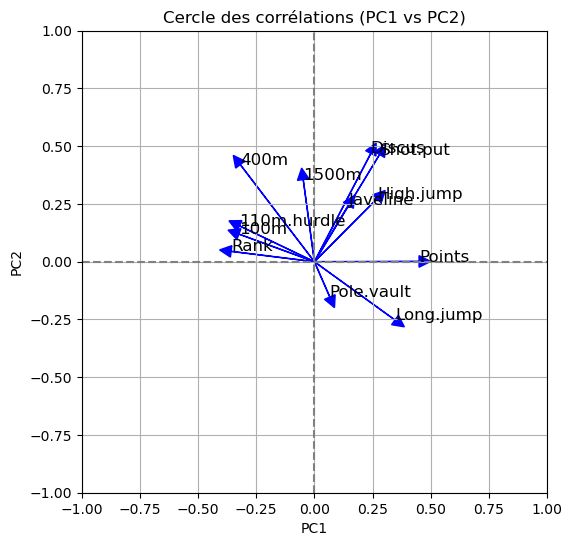

In [11]:
variables = list(df.columns)

fig, ax = plt.subplots(figsize=(6,6))
for i in range(len(variables)):
    ax.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0.05, head_length=0.05, color='b')# trace une flèche partant de (0,0) jusqu'aux coordonnées de la variable
    plt.text(loadings[i, 0], loadings[i, 1], variables[i], fontsize=12)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Cercle des corrélations (PC1 vs PC2)")
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.grid()
plt.show()

In [12]:
import seaborn as sns

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_df)

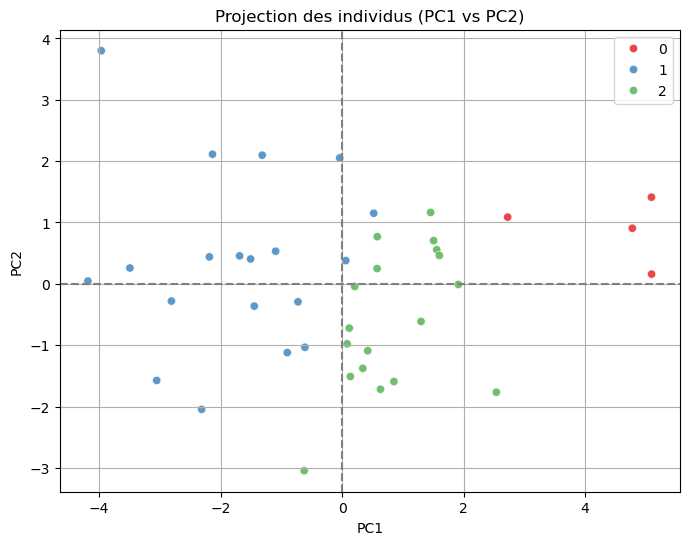

In [14]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_df[:,0], y=pca_df[:,1], hue=clusters, palette="Set1", alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Projection des individus (PC1 vs PC2)")
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.grid()
plt.show()